In [1]:
# Common
import os
import keras
import numpy as np
from tqdm import tqdm
import cv2 as cv
from glob import glob
import tensorflow as tf

# Data 

# Data Viz
import matplotlib.pyplot as plt

# Model 
from keras import Sequential
from keras.layers import Conv2D, Conv2DTranspose, InputLayer, Layer, Input, Dropout, MaxPool2D, concatenate
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

ImportError: cannot import name 'img_to_array' from 'keras.preprocessing.image' (d:\prashant\softwares\Python\lib\site-packages\keras\preprocessing\image.py)

In [ ]:
path = '../input/cityscapes-image-pairs/cityscapes_data/train/'
image_paths = sorted(glob(path + "*.jpg"))
SIZE = 256
images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 3))
masks = np.zeros(shape=(len(image_paths), SIZE, SIZE, 3))

for i in tqdm(range(len(image_paths))):
    path = image_paths[i]
    image = cv.imread(path)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    image = img_to_array(image).astype('float')
    img = image[:,:256,:]/255.0
    img = tf.image.resize(img,(SIZE, SIZE))
    mask = image[:,256:,:]/255.0
    mask = tf.image.resize(mask,(SIZE, SIZE))
    images[i] = img
    masks[i] = mask

  0%|          | 0/2975 [00:00<?, ?it/s]2022-11-22 09:36:08.214866: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-22 09:36:08.215783: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-22 09:36:08.414773: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-22 09:36:08.415633: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-22 09:36:08.416425: I tensorflow/stream_executor/cuda/cuda_gpu_executor.

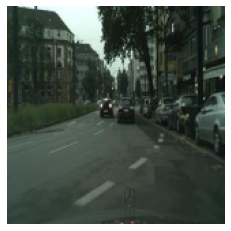

In [ ]:
plt.imshow(images[45])
plt.axis('off')
plt.show()

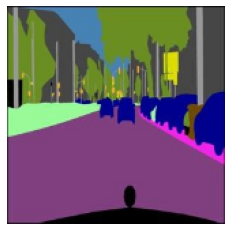

In [ ]:
plt.imshow(masks[45])
plt.axis('off')
plt.show()

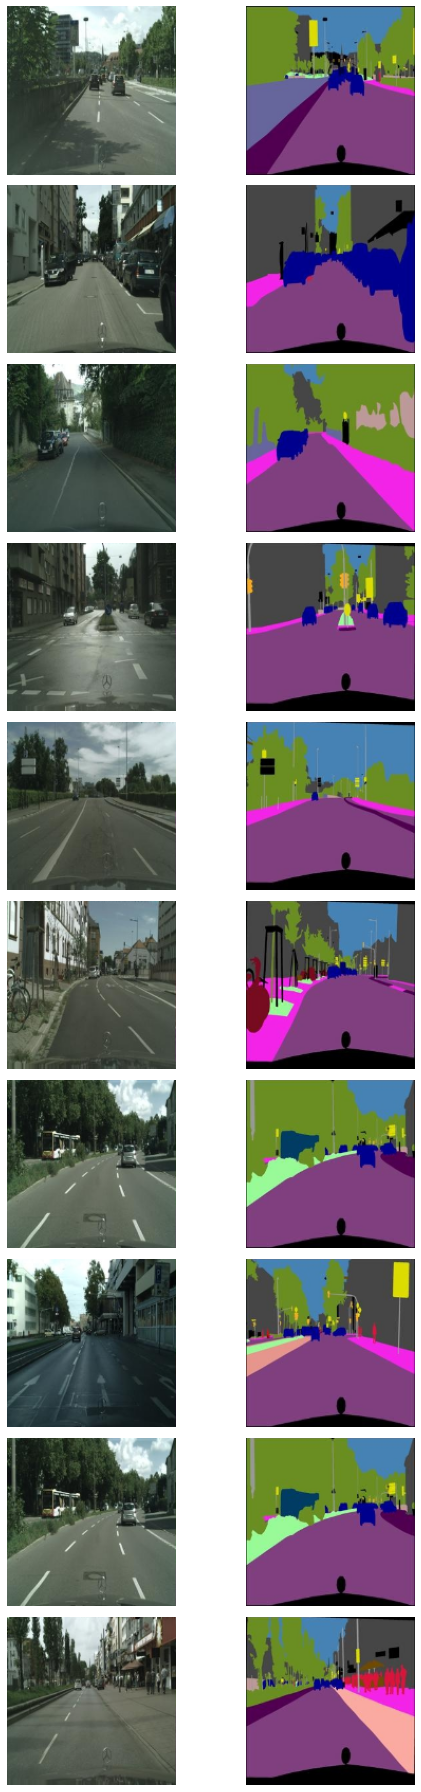

In [ ]:
plt.figure(figsize=(8,25))
for i in range(1,21):
    plt.subplot(10,2,i)
    if i%2!=0:
        id = np.random.randint(len(images))
        image = images[id]
        plt.imshow(image)
        plt.axis('off')
    elif i%2==0:
        mask = masks[id]
        plt.imshow(mask)
        plt.axis('off')  
plt.tight_layout()
plt.show()

In [ ]:
X_train, y_train = images[:2900], masks[:2900]
X_valid, y_valid = images[2900:], masks[2900:]

In [ ]:
class EncoderLayerBlock(Layer):
    def __init__(self, filters, rate, pooling=True):
        super(EncoderLayerBlock, self).__init__()
        self.filters = filters
        self.rate = rate
        self.pooling = pooling

        self.c1 = Conv2D(self.filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')
        self.drop = Dropout(self.rate)
        self.c2 = Conv2D(self.filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')
        self.pool = MaxPool2D(pool_size=(2,2))

    def call(self, X):
        x = self.c1(X)
        x = self.drop(x)
        x = self.c2(x)
        if self.pooling:
            y = self.pool(x)
            return y, x
        else: 
            return x

    def get_config(self):
        base_estimator = super().get_config()
        return {
            **base_estimator,
            "filters":self.filters,
            "rate":self.rate,
            "pooling":self.pooling
        }

#  Decoder Layer
class DecoderLayerBlock(Layer):
    def __init__(self, filters, rate, padding='same'):
            super(DecoderLayerBlock, self).__init__()
            self.filters = filters
            self.rate = rate
            self.cT = Conv2DTranspose(self.filters, kernel_size=3, strides=2, padding=padding)
            self.next = EncoderLayerBlock(self.filters, self.rate, pooling=False)

    def call(self, X):
        X, skip_X = X
        x = self.cT(X)
        c1 = concatenate([x, skip_X])
        y = self.next(c1)
        return y 

    def get_config(self):
        base_estimator = super().get_config()
        return {
            **base_estimator,
            "filters":self.filters,
            "rate":self.rate,
        }

#  Callback 
class ShowProgress(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        id = np.random.randint(len(X_valid))
        rand_img = X_valid[id][np.newaxis,...]
        pred_mask = self.model.predict(rand_img)[0]
        true_mask = y_valid[id]


        plt.subplot(1,3,1)
        plt.imshow(rand_img[0])
        plt.title("Original Image")
        plt.axis('off')


        plt.subplot(1,3,2)
        plt.imshow(pred_mask)
        plt.title("Predicted Mask")
        plt.axis('off')

        plt.subplot(1,3,3)
        plt.imshow(true_mask)
        plt.title("True Mask")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

2022-11-22 09:37:04.990272: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-11-22 09:37:08.668333: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


91/91 [==============================] - 31s 172ms/step - loss: 0.6354 - accuracy: 0.3771 - mean_io_u: 0.5000 - val_loss: 0.6257 - val_accuracy: 0.4243 - val_mean_io_u: 0.5000


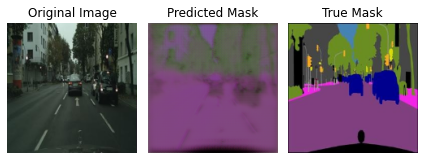

Epoch 2/50
91/91 [==============================] - 12s 134ms/step - loss: 0.6011 - accuracy: 0.4568 - mean_io_u: 0.5000 - val_loss: 0.6104 - val_accuracy: 0.6703 - val_mean_io_u: 0.5000


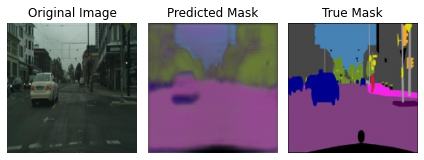

Epoch 3/50
91/91 [==============================] - 12s 134ms/step - loss: 0.5922 - accuracy: 0.5547 - mean_io_u: 0.5000 - val_loss: 0.5945 - val_accuracy: 0.6284 - val_mean_io_u: 0.5000


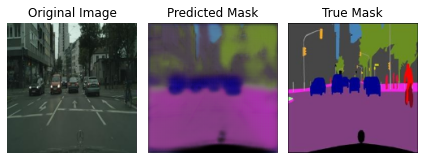

Epoch 4/50
91/91 [==============================] - 12s 135ms/step - loss: 0.5842 - accuracy: 0.5882 - mean_io_u: 0.5000 - val_loss: 0.5902 - val_accuracy: 0.7041 - val_mean_io_u: 0.5000


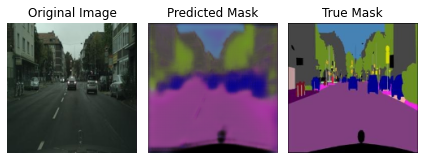

Epoch 5/50
91/91 [==============================] - 12s 137ms/step - loss: 0.5788 - accuracy: 0.6163 - mean_io_u: 0.5000 - val_loss: 0.5854 - val_accuracy: 0.7059 - val_mean_io_u: 0.5000


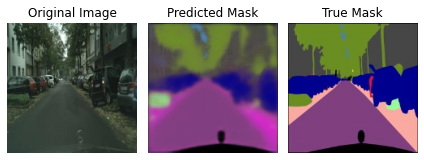

Epoch 6/50
91/91 [==============================] - 13s 140ms/step - loss: 0.5747 - accuracy: 0.6354 - mean_io_u: 0.5000 - val_loss: 0.5850 - val_accuracy: 0.6103 - val_mean_io_u: 0.5000


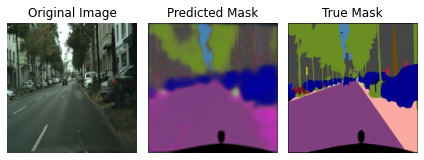

Epoch 7/50
91/91 [==============================] - 13s 140ms/step - loss: 0.5719 - accuracy: 0.6509 - mean_io_u: 0.5000 - val_loss: 0.5824 - val_accuracy: 0.7419 - val_mean_io_u: 0.5000


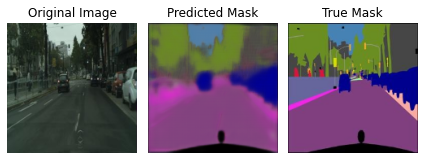

Epoch 8/50
91/91 [==============================] - 13s 140ms/step - loss: 0.5700 - accuracy: 0.6634 - mean_io_u: 0.5000 - val_loss: 0.5822 - val_accuracy: 0.7482 - val_mean_io_u: 0.5000


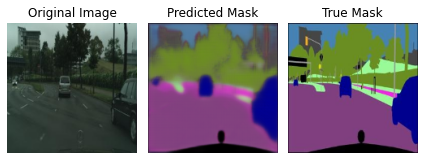

Epoch 9/50
91/91 [==============================] - 13s 140ms/step - loss: 0.5673 - accuracy: 0.6738 - mean_io_u: 0.5000 - val_loss: 0.5805 - val_accuracy: 0.7493 - val_mean_io_u: 0.5000


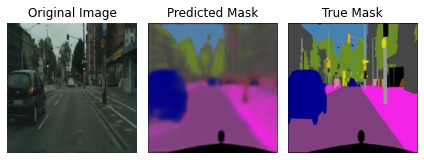

Epoch 10/50
91/91 [==============================] - 13s 138ms/step - loss: 0.5666 - accuracy: 0.6831 - mean_io_u: 0.5000 - val_loss: 0.5818 - val_accuracy: 0.7427 - val_mean_io_u: 0.5000


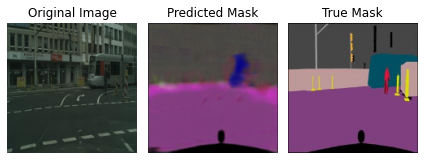

Epoch 11/50
91/91 [==============================] - 13s 139ms/step - loss: 0.5646 - accuracy: 0.6855 - mean_io_u: 0.5000 - val_loss: 0.5810 - val_accuracy: 0.7152 - val_mean_io_u: 0.5000


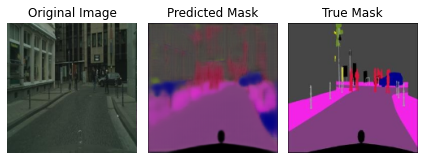

Epoch 12/50
91/91 [==============================] - 13s 139ms/step - loss: 0.5637 - accuracy: 0.6856 - mean_io_u: 0.5000 - val_loss: 0.5794 - val_accuracy: 0.7301 - val_mean_io_u: 0.5000


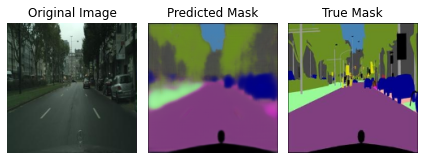

Epoch 13/50
91/91 [==============================] - 13s 139ms/step - loss: 0.5628 - accuracy: 0.6894 - mean_io_u: 0.5000 - val_loss: 0.5778 - val_accuracy: 0.7425 - val_mean_io_u: 0.5000


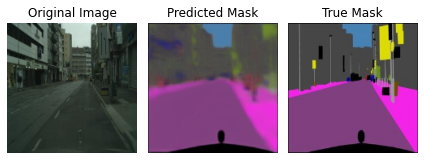

Epoch 14/50
91/91 [==============================] - 13s 139ms/step - loss: 0.5617 - accuracy: 0.6855 - mean_io_u: 0.5000 - val_loss: 0.5778 - val_accuracy: 0.7391 - val_mean_io_u: 0.5000


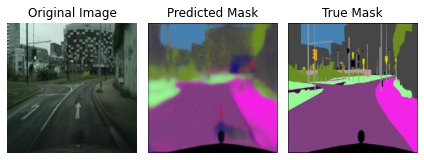

Epoch 15/50
91/91 [==============================] - 13s 139ms/step - loss: 0.5606 - accuracy: 0.6924 - mean_io_u: 0.5000 - val_loss: 0.5791 - val_accuracy: 0.7575 - val_mean_io_u: 0.5000


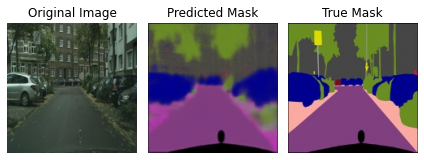

Epoch 16/50
91/91 [==============================] - 13s 138ms/step - loss: 0.5602 - accuracy: 0.6865 - mean_io_u: 0.5000 - val_loss: 0.5767 - val_accuracy: 0.7482 - val_mean_io_u: 0.5000


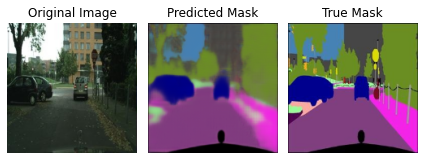

Epoch 17/50
91/91 [==============================] - 13s 140ms/step - loss: 0.5589 - accuracy: 0.6879 - mean_io_u: 0.5000 - val_loss: 0.5758 - val_accuracy: 0.6708 - val_mean_io_u: 0.5000


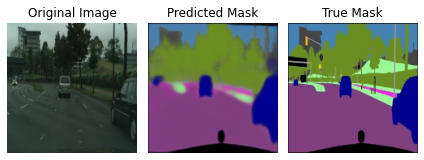

Epoch 18/50
91/91 [==============================] - 13s 138ms/step - loss: 0.5585 - accuracy: 0.6887 - mean_io_u: 0.5000 - val_loss: 0.5759 - val_accuracy: 0.7686 - val_mean_io_u: 0.5000


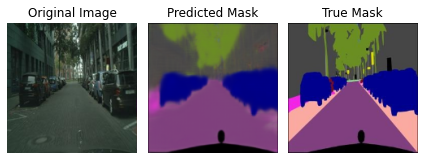

Epoch 19/50
91/91 [==============================] - 13s 139ms/step - loss: 0.5588 - accuracy: 0.6918 - mean_io_u: 0.5000 - val_loss: 0.5747 - val_accuracy: 0.7640 - val_mean_io_u: 0.5000


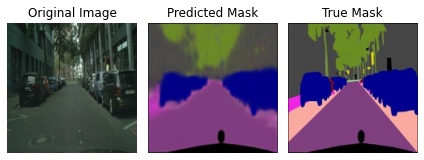

Epoch 20/50
91/91 [==============================] - 13s 138ms/step - loss: 0.5579 - accuracy: 0.6921 - mean_io_u: 0.5000 - val_loss: 0.5751 - val_accuracy: 0.7707 - val_mean_io_u: 0.5000


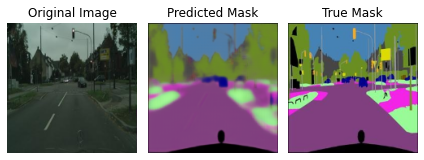

Epoch 21/50
91/91 [==============================] - 13s 139ms/step - loss: 0.5573 - accuracy: 0.6915 - mean_io_u: 0.5000 - val_loss: 0.5743 - val_accuracy: 0.7259 - val_mean_io_u: 0.5000


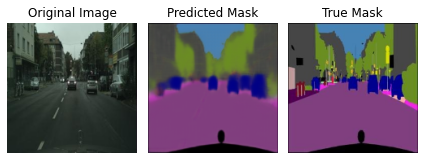

Epoch 22/50
91/91 [==============================] - 13s 139ms/step - loss: 0.5566 - accuracy: 0.6954 - mean_io_u: 0.5000 - val_loss: 0.5759 - val_accuracy: 0.7590 - val_mean_io_u: 0.5000


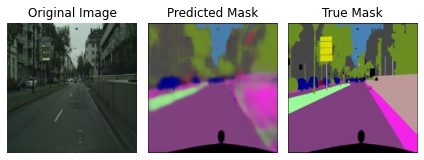

Epoch 23/50
91/91 [==============================] - 13s 138ms/step - loss: 0.5559 - accuracy: 0.6925 - mean_io_u: 0.5000 - val_loss: 0.5750 - val_accuracy: 0.7372 - val_mean_io_u: 0.5000


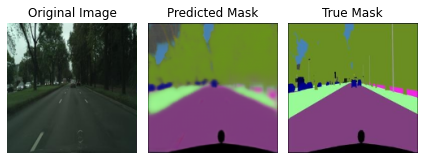

Epoch 24/50
91/91 [==============================] - 13s 139ms/step - loss: 0.5555 - accuracy: 0.6930 - mean_io_u: 0.5000 - val_loss: 0.5737 - val_accuracy: 0.7358 - val_mean_io_u: 0.5000


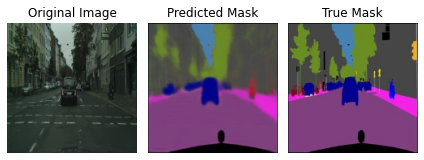

Epoch 25/50
91/91 [==============================] - 13s 139ms/step - loss: 0.5557 - accuracy: 0.6977 - mean_io_u: 0.5000 - val_loss: 0.5764 - val_accuracy: 0.7363 - val_mean_io_u: 0.5000


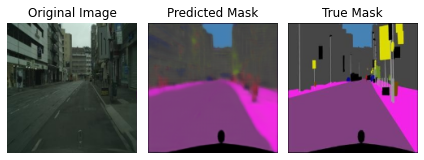

Epoch 26/50
91/91 [==============================] - 13s 139ms/step - loss: 0.5555 - accuracy: 0.6986 - mean_io_u: 0.5000 - val_loss: 0.5734 - val_accuracy: 0.7069 - val_mean_io_u: 0.5000


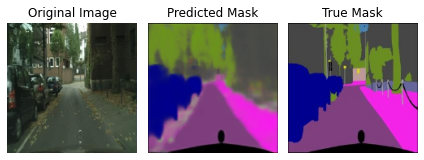

Epoch 27/50
91/91 [==============================] - 13s 139ms/step - loss: 0.5547 - accuracy: 0.6994 - mean_io_u: 0.5000 - val_loss: 0.5750 - val_accuracy: 0.7544 - val_mean_io_u: 0.5000


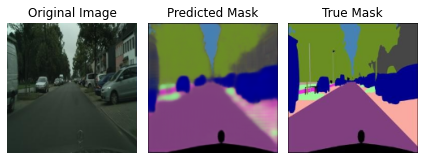

Epoch 28/50
91/91 [==============================] - 13s 139ms/step - loss: 0.5544 - accuracy: 0.7001 - mean_io_u: 0.5000 - val_loss: 0.5730 - val_accuracy: 0.7487 - val_mean_io_u: 0.5000


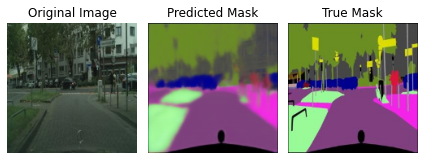

Epoch 29/50
91/91 [==============================] - 13s 139ms/step - loss: 0.5538 - accuracy: 0.7022 - mean_io_u: 0.5000 - val_loss: 0.5729 - val_accuracy: 0.7371 - val_mean_io_u: 0.5000


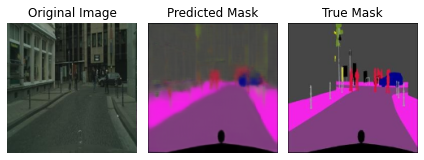

Epoch 30/50
91/91 [==============================] - 13s 138ms/step - loss: 0.5535 - accuracy: 0.7041 - mean_io_u: 0.5000 - val_loss: 0.5732 - val_accuracy: 0.7265 - val_mean_io_u: 0.5000


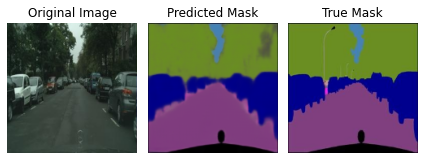

Epoch 31/50
91/91 [==============================] - 13s 139ms/step - loss: 0.5531 - accuracy: 0.7042 - mean_io_u: 0.5000 - val_loss: 0.5747 - val_accuracy: 0.7552 - val_mean_io_u: 0.5000


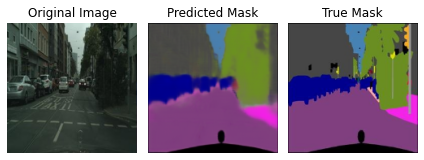

Epoch 32/50
91/91 [==============================] - 13s 138ms/step - loss: 0.5533 - accuracy: 0.7054 - mean_io_u: 0.5000 - val_loss: 0.5744 - val_accuracy: 0.7510 - val_mean_io_u: 0.5000


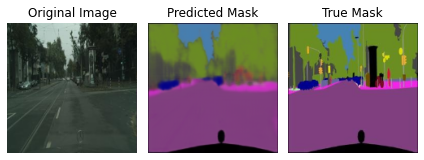

Epoch 33/50
91/91 [==============================] - 13s 138ms/step - loss: 0.5532 - accuracy: 0.7036 - mean_io_u: 0.5000 - val_loss: 0.5728 - val_accuracy: 0.7164 - val_mean_io_u: 0.5000


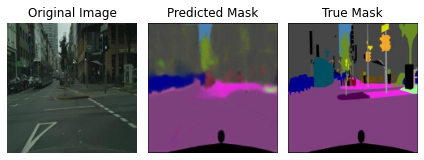

Epoch 34/50
91/91 [==============================] - 13s 139ms/step - loss: 0.5524 - accuracy: 0.7116 - mean_io_u: 0.5000 - val_loss: 0.5734 - val_accuracy: 0.7610 - val_mean_io_u: 0.5000


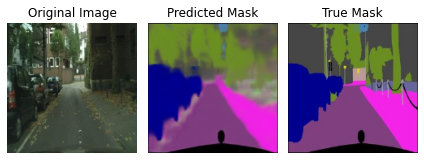

Epoch 35/50
91/91 [==============================] - 13s 139ms/step - loss: 0.5523 - accuracy: 0.7124 - mean_io_u: 0.5000 - val_loss: 0.5736 - val_accuracy: 0.7082 - val_mean_io_u: 0.5000


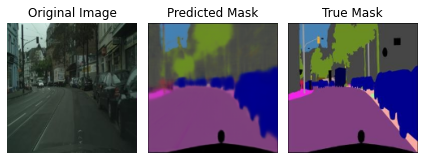

Epoch 36/50
91/91 [==============================] - 13s 138ms/step - loss: 0.5518 - accuracy: 0.7083 - mean_io_u: 0.5000 - val_loss: 0.5731 - val_accuracy: 0.7167 - val_mean_io_u: 0.5000


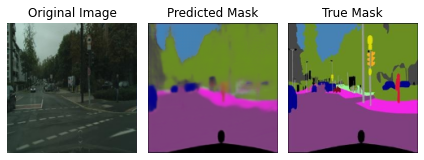

Epoch 37/50
91/91 [==============================] - 13s 140ms/step - loss: 0.5511 - accuracy: 0.7108 - mean_io_u: 0.5000 - val_loss: 0.5733 - val_accuracy: 0.7343 - val_mean_io_u: 0.5000


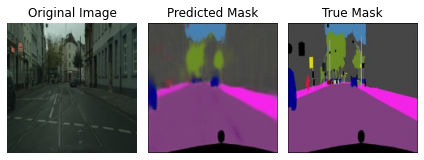

Epoch 38/50
91/91 [==============================] - 13s 139ms/step - loss: 0.5509 - accuracy: 0.7154 - mean_io_u: 0.5000 - val_loss: 0.5738 - val_accuracy: 0.7095 - val_mean_io_u: 0.5000


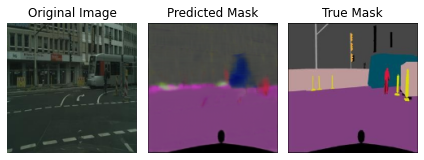

In [ ]:
with tf.device('/GPU:0'):
    # Input Layer 
    input_layer = Input(shape=X_train.shape[-3:])

    # Encoder
    p1, c1 = EncoderLayerBlock(16,0.1)(input_layer)
    p2, c2 = EncoderLayerBlock(32,0.1)(p1)
    p3, c3 = EncoderLayerBlock(64,0.2)(p2)
    p4, c4 = EncoderLayerBlock(128,0.2)(p3)

    # Encoding Layer
    c5 = EncoderLayerBlock(256,0.3,pooling=False)(p4)

    # Decoder
    d1 = DecoderLayerBlock(128,0.2)([c5, c4])
    d2 = DecoderLayerBlock(64,0.2)([d1, c3])
    d3 = DecoderLayerBlock(32,0.2)([d2, c2])
    d4 = DecoderLayerBlock(16,0.2)([d3, c1])

    # Output layer
    output = Conv2D(3,kernel_size=1,strides=1,padding='same',activation='softmax')(d4)

    # U-Net Model
    model = keras.models.Model(
        inputs=[input_layer],
        outputs=[output],
    )

    # Compiling
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=0.001),
        metrics=['accuracy', keras.metrics.MeanIoU(num_classes=2)]
    )

    # Callbacks 
    callbacks =[
        EarlyStopping(patience=5, restore_best_weights=True),
        ModelCheckpoint("UNet-Colorizer.h5", save_best_only=True),
        ShowProgress()
    ]

    # Train The Model
    model.fit(
        X_train, y_train,
        validation_data=(X_valid, y_valid),
        epochs=100,
        callbacks=callbacks
    )

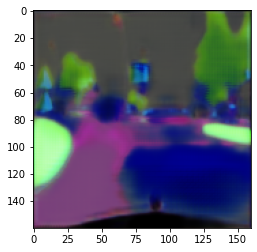

In [ ]:
img='../input/cityscapes-image-pairs/cityscapes_data/train/1.jpg'
import cv2
im=cv2.imread(img)
im=im[:,256:,:]
im=cv2.resize(im,(160,160))
im=np.array(im)
im=im/255
im=np.expand_dims(im,axis=0)
pred=model.predict(im)
plt.imshow(pred[0])
plt.show()

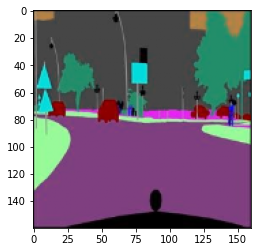

In [ ]:
img='../input/cityscapes-image-pairs/cityscapes_data/train/1.jpg'
import cv2
im=cv2.imread(img)
im=im[:,256:,:]
im=cv2.resize(im,(160,160))
im=np.array(im)
im=im/255
plt.imshow(im)
plt.show()